# Miscellaneous scripts to examinate diffusion models

## Imports

In [1]:
import os
import torch
import numpy as np
import pickle
import argparse
import torchvision.utils as vutils
from diffusion_utils.utils import add_parent_path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Data
add_parent_path(level=1)
from datasets.data import get_data, get_data_id, add_data_args, get_plot_transform

# Model
from model import get_model, get_model_id, add_model_args
from diffusion_utils.base import DataParallelDistribution
from diffusion_utils.diffusion_multinomial import index_to_log_onehot, log_onehot_to_index

## Setup

###  Model path and args

In [ ]:
###########
## Setup ##
###########

seed = 0
model_path = '/export/fhome2/denis/bct_generation_data_and_results/multinomial_diffusion/log/ct_chosen_coronal/partial_diffusion/multistep/test_implementation'

path_args = '{}/args.pickle'.format(model_path)
path_check = '{}/check/checkpoint1.pt'.format(model_path)

torch.manual_seed(seed)

###############
## Load args ##
###############

with open(path_args, 'rb') as f:
    args = pickle.load(f)

args.loss_weighted = False
args.conditional = False
args.partial = True

### Get data and model

In [3]:
##################
## Specify data ##
##################

train_loader, test_loader, data_shape, num_classes = get_data(args)
minibatch_data = None
for minibatch_data in train_loader:
    break
assert minibatch_data is not None

Dataset loaded from /export/fhome2/denis/bct_generation_data_and_results/multinomial_diffusion/data/ct_chosen_coronal/data.pkl
Dataset loaded from /export/fhome2/denis/bct_generation_data_and_results/multinomial_diffusion/data/ct_chosen_coronal/data.pkl


In [4]:
###################
## Specify model ##
###################

model = get_model(args, data_shape=data_shape)
if args.parallel == 'dp':
    model = DataParallelDistribution(model)

if torch.cuda.is_available():
    checkpoint = torch.load(path_check)
else:
    checkpoint = torch.load(path_check, map_location='cpu')
model.load_state_dict(checkpoint['model'])

if torch.cuda.is_available():
    model = model.cuda()

print('Loaded weights for model at {}/{} epochs'.format(checkpoint['current_epoch'], args.epochs))
device = model.log_alpha.device

Data shape: (1, 512, 512)


/tmp/ipykernel_31036/3618621467.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_check)


Loaded weights for model at 250/1000 epochs


### Plotting

In [8]:
K = model.num_classes
gray_shades = [(1/(K-1) * k, 1/(K-1) * k, 1/(K-1) * k) for k in range(K)]
gcmap = ListedColormap(gray_shades)
def custom_plot(img_list, title=None, show=True, save=False):
    n = len(img_list)
    fig, axs = plt.subplots(1, n, figsize = (n * 4, 4 + 1))
    for i, img in enumerate(img_list):
        axs[i].imshow(img.cpu().numpy(), cmap = gcmap, vmin=0, vmax=K-1)
        axs[i].axis('off')
    if title is not None:
        fig.suptitle(title)
    plt.show()

## Conditional Sampling

In [5]:
num_classes = model.num_classes

In [ ]:
# Get a batched tensor of num_samples of the test_loader

num_samples = 16
xs, ys = [], []
c = 0
for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    b = len(x) #which is also == len(y)
    d = min(b, num_samples - c)
    c += d
    xs.append(x[:d])
    ys.append(y[:d])
    if c >= num_samples:
        break
x = torch.cat(xs, dim=0)
y = torch.cat(ys, dim=0)

ValueError: too many values to unpack (expected 2)

In [7]:
print(x.shape, y.shape)

torch.Size([16, 512, 512]) torch.Size([16, 512, 512])


In [ ]:
#num_samples = 3
#_, y = next(iter(test_loader)) #to be fixed in case batch_size < num_samples
#y = y[:num_samples]
with torch.no_grad():
    samples = model.sample(num_samples, y.to(args.device)).cpu()

In [69]:
#Custom grey-level colormap for plotting
K = model.num_classes
gray_shades = [(1/(K-1) * k, 1/(K-1) * k, 1/(K-1) * k) for k in range(K)]
gcmap = ListedColormap(gray_shades)

N = len(x)
fig, axs = plt.subplots(2, N, figsize = ((N) * 4, 9))
for i in range(N):
    axs[0, i].imshow(samples[i][0].cpu().numpy(), cmap = gcmap, vmin=0, vmax=K-1)
    axs[0, i].axis('off')
    axs[0, i].set_title('Conditional Sample')

    axs[1, i].imshow(x[i].cpu().numpy(), cmap = gcmap, vmin=0, vmax=K-1)
    axs[1, i].axis('off')
    axs[1, i].set_title('Original')

plt.savefig('conditional_samples_test.png')

NameError: name 'x' is not defined

## Sampling

In [16]:
num_samples = 3
with torch.no_grad():
    u = model.sample(num_samples).cpu()

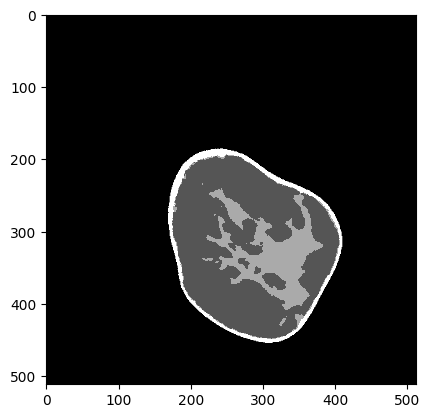

In [37]:
plt.imshow(u[0, 0], cmap = gcmap, vmin=0, vmax=K-1)

## Miscs

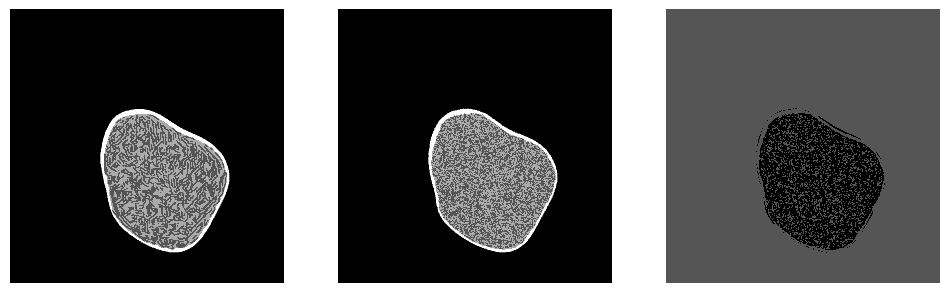

In [38]:
batch = next(iter(test_loader)).to(device)
log_batch = index_to_log_onehot(batch, num_classes)

log_x0 = log_batch[3].unsqueeze(0)
x0 = log_onehot_to_index(log_x0)
x0 = u[0, 0].to(device)
x0 = x0.reshape(1, *x0.shape)

#hide the interior
x0 = torch.where((x0 == 1) | (x0 == 2), torch.randint(1, 3, (1, 512, 512)).to(device), x0)
log_x0 = index_to_log_onehot(x0, num_classes)
t = torch.full((1,), 0, device=device, dtype=torch.long)
log_x0_hat = log_x0
iters = 10
for _ in range(iters):
    log_x0_hat = model.predict_start(log_x_t=log_x0_hat, t=t)
    log_x0_hat = index_to_log_onehot(log_onehot_to_index(log_x0_hat), num_classes)
x0_hat = log_onehot_to_index(log_x0_hat)
x0 = log_onehot_to_index(log_x0)
diff = (x0_hat[0] == x0[0]).int()
custom_plot([x0_hat[0], x0[0], diff])

In [ ]:
############
## Sample ##
############


""" path_samples = 'samples/sample_ep{}_s{}.png'.format(checkpoint['current_epoch'], eval_args.seed)
if not os.path.exists(os.path.dirname(path_samples)):
    os.mkdir(os.path.dirname(path_samples)) """

#deciding whether to put a constraint or not: 
#ToDo
constraint = None
chain_samples = eval_args.samples
with torch.no_grad():
    samples_chain = model.sample_chain(chain_samples, constraint=constraint)

print('shape:, ', samples_chain.shape)

#Custom grey-level colormap for plotting
K = model.num_classes
gray_shades = [(1/(K-1) * k, 1/(K-1) * k, 1/(K-1) * k) for k in range(K)]
gcmap = ListedColormap(gray_shades)

T = len(samples_chain)
h = 100
N = T // h
fig, axs = plt.subplots(1, N+1, figsize = ((N+1) * 4, 4))
for i in range(N+1):
    axs[i].imshow(samples_chain[max(i * h - 1, 0)][0][0].cpu().numpy(), cmap = gcmap, vmin=0, vmax=K-1)
    axs[i].axis('off')
    axs[i].set_title('t = {}'.format(max(i * h - 1, 0)+1))
plt.savefig('chain_sample.png')

## Inpainting

In [13]:
num_classes = model.num_classes
originals = 1
num_samples = 1

In [14]:
#getting the x0s to inpaint
x0s = []
for batch in train_loader:
    for i in range(batch.size(0)):
        if len(x0s) < originals:
            x0s.append(batch[i])
        else:
            break
    if len(x0s) == originals:
        break

/net/fraifbucnec102.storage.ge-healthcare.net/nfs/BUC_VOL12_MIX_migr_ph1/frbucx05nvsr01n/static02/tomo-database/bcare/accounts/duval_d/venv/lib/python3.11/site-packages/diffusion_utils/diffusion_multinomial.py:474: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.int64)
/net/fraifbucnec102.storage.ge-healthcare.net/nfs/BUC_VOL12_MIX_migr_ph1/frbucx05nvsr01n/static02/tomo-database/bcare/accounts/duval_d/venv/lib/python3.11/site-packages/diffusion_utils/diffusion_multinomial.py:479: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


KeyboardInterrupt: 

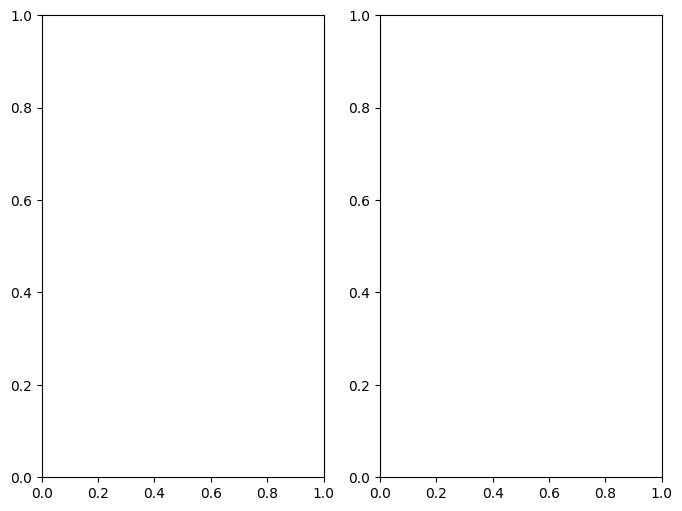

In [ ]:
fig, axs = plt.subplots(len(x0s), num_samples+1, figsize=((num_samples+1)* 4, len(x0s) * 4 + 2))
for i, x0 in enumerate(x0s):
    x0 = x0.unsqueeze(0)
    mask = torch.where((x0 == 1) | (x0 == 2), 0, 1)
    categories = [1, 2]
    with torch.no_grad():
        samples = model.sample_masked(num_samples, x0, mask, categories).cpu().numpy()

    axs[i, 0].imshow(x0[0].cpu().numpy(), cmap = gcmap, vmin=0, vmax=K-1)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original')
    for j, sample in enumerate(samples):
        axs[i, j+1].imshow(sample[0], cmap = gcmap, vmin=0, vmax=K-1)
        axs[i, j+1].axis('off')
        axs[i, j+1].set_title('Sample {}'.format(j+1))

In [40]:
x0 = u[0, 0].to(device)
x0 = x0.reshape(1, *x0.shape)
mask = torch.where((x0 == 1) | (x0 == 2), 0, 1)
categories = [1, 2]
with torch.no_grad():
    samples_chain = model.sample_masked_chain(2, x0, mask, categories).cpu().numpy()

/net/fraifbucnec102.storage.ge-healthcare.net/nfs/BUC_VOL12_MIX_migr_ph1/frbucx05nvsr01n/static02/tomo-database/bcare/accounts/duval_d/venv/lib/python3.11/site-packages/diffusion_utils/diffusion_multinomial.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.int64)
/net/fraifbucnec102.storage.ge-healthcare.net/nfs/BUC_VOL12_MIX_migr_ph1/frbucx05nvsr01n/static02/tomo-database/bcare/accounts/duval_d/venv/lib/python3.11/site-packages/diffusion_utils/diffusion_multinomial.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


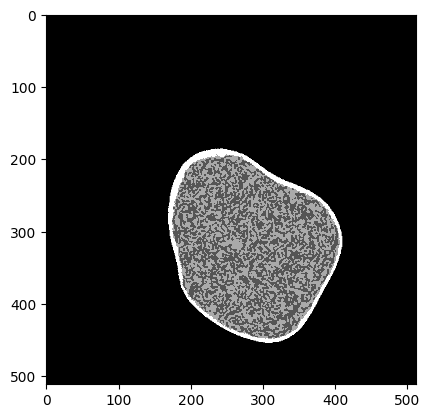

In [45]:
plt.imshow(samples_chain[0][1][0], cmap = gcmap, vmin=0, vmax=K-1)

In [ ]:
plt.show()

In [ ]:
plt.savefig('inpainted_samples.png')